Requirements (the Captchanet library is **not required** to run inference):
- Python 3.7
- `tensorflow >= 2.0`: to load and execute the model.
- `numpy`: you know...
- `tqdm`: a progress bar.
- `matplotlib`: to plot things.
- `requests`: to download stuff on the internet.
- `pillow`: to convert a raw string to an image array.

`pip install tensorflow==2.0.0-beta1 numpy tqdm matplotlib requests pillow`

In [7]:
# Use this to disable GPU.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

from pathlib import Path
import io
import tempfile
import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image

import requests
from tqdm.auto import tqdm
from tqdm.auto import trange


# Useful functions.

class _TqdmUpTo(tqdm):
  """Alternative Class-based version of the above.
  Provides `update_to(n)` which uses `tqdm.update(delta_n)`.
  Inspired by [twine#242](https://github.com/pypa/twine/pull/242),
  [here](https://github.com/pypa/twine/commit/42e55e06).
  """

  def update_to(self, b=1, bsize=1, tsize=None):
    """
    Args:
        b: int, optional
            Number of blocks transferred so far [default: 1].
        bsize: int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize: int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
    """
    if tsize is not None:
      self.total = tsize
    self.update(b * bsize - self.n)  # will also set self.n = b * bsize


def download_zip(zip_url, extract_folder_path, progressbar=True):
  """Download a ZIP file from an URL and extract to a given local folder.

  Args:
      zip_url: The URL to the ZIP file as a str.
      extract_folder_path: The path to the local folder for the extraction.
  """
  import urllib
  import tempfile
  import os
  import zipfile

  temp_path = tempfile.mktemp(suffix=".zip")

  with _TqdmUpTo(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, disable=not progressbar) as t:
    urllib.request.urlretrieve(zip_url, filename=temp_path, reporthook=t.update_to, data=None)

  with zipfile.ZipFile(temp_path) as zf:
    zf.extractall(extract_folder_path)

  os.remove(temp_path)

### Get the captchanet model

In [2]:
# Here we use a temporary folder to store the model but any other folder work.
model_path = Path(tempfile.mkdtemp())

# Download the model to `model_path`.
model_url = "https://storage.googleapis.com/hadim-data/models/captchanet-rip-v6.zip"
download_zip(model_url, model_path)

### Load the model

In [3]:
# Load the model in memory
model = tf.saved_model.load(str(model_path / 'inference_model'))

### Get images

In [19]:
# Download some captcha images
batch_size = 8
captcha_url = "https://www.referendum.interieur.gouv.fr/bundles/ripconsultation/securimage/securimage_show.php"
images = [np.array(Image.open(io.BytesIO(requests.get(captcha_url).content))) for _ in trange(batch_size)]
images = np.array(images)

# `images` has the shape: [BATCH, WIDTH, HEIGHT, CHANNEL]

### Solve captcha

In [20]:
# Here we run the model
start = datetime.datetime.now()
words = model.solve(images)
duration = datetime.datetime.now() - start
words = words.numpy()

duration_s = duration.total_seconds()
f"Inference on {batch_size} images took {duration_s:.4f}s ({duration_s/batch_size:.4f}s/image)"

'Inference on 8 images took 0.1332s (0.0166s/image)'

### Display the result

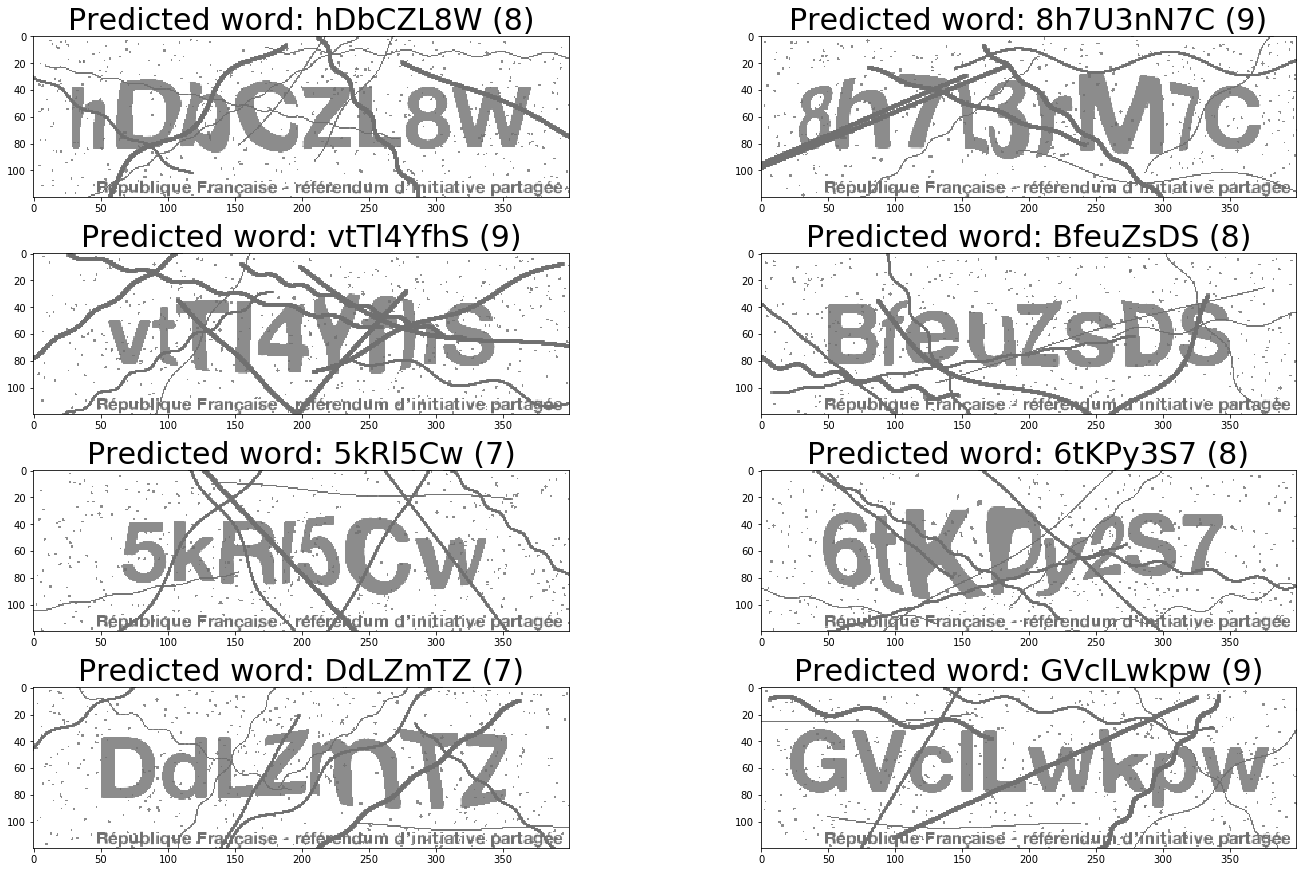

In [21]:
# Plot the images with the predicted words.
size = 3
ncols = 2
nrows = batch_size // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, ax in zip(images, words, axs):
  ax.imshow(image)
  text = f'Predicted word: {word.decode()} ({len(word)})'
  ax.set_title(text, fontsize=30)